# Health data analysis

Oura ring data for last 3 years
captures HRV, Sleep, Exercise etc...

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pytz

from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mutual_info_score
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler





In [ ]:
# Load data
df = pd.read_csv('data/data.csv')


In [ ]:
# look at data
df.head()

,date,Temperature Trend Deviation,Total Burn,Bedtime Start,Long Periods of Inactivity,Inactive Time,Sleep Balance Score,HRV Balance Score,Training Frequency Score,Readiness Score,...,Previous Day Activity Score,REM Sleep Duration,Average MET,Total Sleep Score,Total Bedtime,Sleep Efficiency Score,Recovery Index Score,Training Volume Score,Meet Daily Targets Score,Restless Sleep
0,2020-04-14,NaN,2594,2020-04-13T22:51:07.000-07:00,2,41040,NaN,NaN,100,90.0,...,NaN,6450.0,1.50000,77.0,25740.0,97.0,97.0,99,78,234.0
1,2020-04-15,NaN,2385,2020-04-14T21:36:31.000-07:00,1,42960,NaN,NaN,100,92.0,...,75.0,9000.0,1.37500,96.0,30660.0,100.0,100.0,99,60,279.0
2,2020-04-16,0.04,2440,2020-04-15T22:12:33.000-07:00,0,44700,NaN,NaN,100,79.0,...,79.0,7950.0,1.43750,81.0,28140.0,88.0,80.0,98,43,170.0
3,2020-04-17,0.04,2481,2020-04-16T23:14:24.000-07:00,2,40440,89.0,NaN,100,88.0,...,88.0,7110.0,1.46875,83.0,28140.0,95.0,97.0,98,43,222.0
4,2020-04-18,0.03,2466,2020-04-17T23:41:30.000-07:00,0,24960,83.0,NaN,100,78.0,...,93.0,4620.0,1.43750,74.0,25920.0,93.0,41.0,99,43,168.0


In [5]:
df.isna().sum()/len(df)

date                           0.000000
Temperature Trend Deviation    0.060961
Total Burn                     0.000000
Bedtime Start                  0.043376
Long Periods of Inactivity     0.000000
Inactive Time                  0.000000
Sleep Balance Score            0.045135
HRV Balance Score              0.047479
Training Frequency Score       0.000000
Readiness Score                0.043376
Resting Heart Rate Score       0.044549
Non-wear Time                  0.000000
Temperature Deviation (°C)     0.053341
Steps                          0.000000
Deep Sleep Duration            0.043376
Low Activity Time              0.000000
Average HRV                    0.044549
Respiratory Rate               0.043376
Activity Burn                  0.000000
Deep Sleep Score               0.043376
Total Sleep Duration           0.043376
Restfulness Score              0.043376
Sleep Timin Score              0.043376
Previous Night Score           0.047479
Sleep Latency                  0.043376


In [6]:
# remove NAs
df = df.dropna()

In [7]:
# check type of data
df.dtypes

date                            object
Temperature Trend Deviation    float64
Total Burn                       int64
Bedtime Start                   object
Long Periods of Inactivity       int64
Inactive Time                    int64
Sleep Balance Score            float64
HRV Balance Score              float64
Training Frequency Score         int64
Readiness Score                float64
Resting Heart Rate Score       float64
Non-wear Time                    int64
Temperature Deviation (°C)     float64
Steps                            int64
Deep Sleep Duration            float64
Low Activity Time                int64
Average HRV                    float64
Respiratory Rate               float64
Activity Burn                    int64
Deep Sleep Score               float64
Total Sleep Duration           float64
Restfulness Score              float64
Sleep Timin Score              float64
Previous Night Score           float64
Sleep Latency                  float64
Equivalent Walking Distan

In [12]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df = df.set_index('date')



In [13]:
#remove columns with 'score' in the name

df_copy = df.copy()
df_copy = df_copy.loc[:, ~df_copy.columns.str.contains('score', case=False)]
print("Current Columns: ",df_copy.columns)
print("removed columns: ",df.columns[df.columns.str.contains('score', case=False)])

Current Columns:  Index(['Temperature Trend Deviation', 'Total Burn', 'Bedtime Start',
       'Long Periods of Inactivity', 'Inactive Time', 'Non-wear Time',
       'Temperature Deviation (°C)', 'Steps', 'Deep Sleep Duration',
       'Low Activity Time', 'Average HRV', 'Respiratory Rate', 'Activity Burn',
       'Total Sleep Duration', 'Sleep Latency', 'Equivalent Walking Distance',
       'Sleep Efficiency', 'Bedtime End', 'Medium Activity Time',
       'Lowest Resting Heart Rate', 'Average Resting Heart Rate', 'Awake Time',
       'Sleep Timing', 'Light Sleep Duration', 'Rest Time',
       'High Activity Time', 'REM Sleep Duration', 'Average MET',
       'Total Bedtime ', 'Restless Sleep'],
      dtype='object')
removed columns:  Index(['Sleep Balance Score', 'HRV Balance Score', 'Training Frequency Score',
       'Readiness Score', 'Resting Heart Rate Score', 'Deep Sleep Score',
       'Restfulness Score', 'Sleep Timin Score', 'Previous Night Score',
       'Temperature Score', 'Sle

In [ ]:
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()
# Standardize numeric columns | note that we don't have to import any packages for this.
scaler = StandardScaler() 
df_copy[numeric_cols] = scaler.fit_transform(df_copy[numeric_cols])

In [18]:
df_copy = df_copy.reset_index()

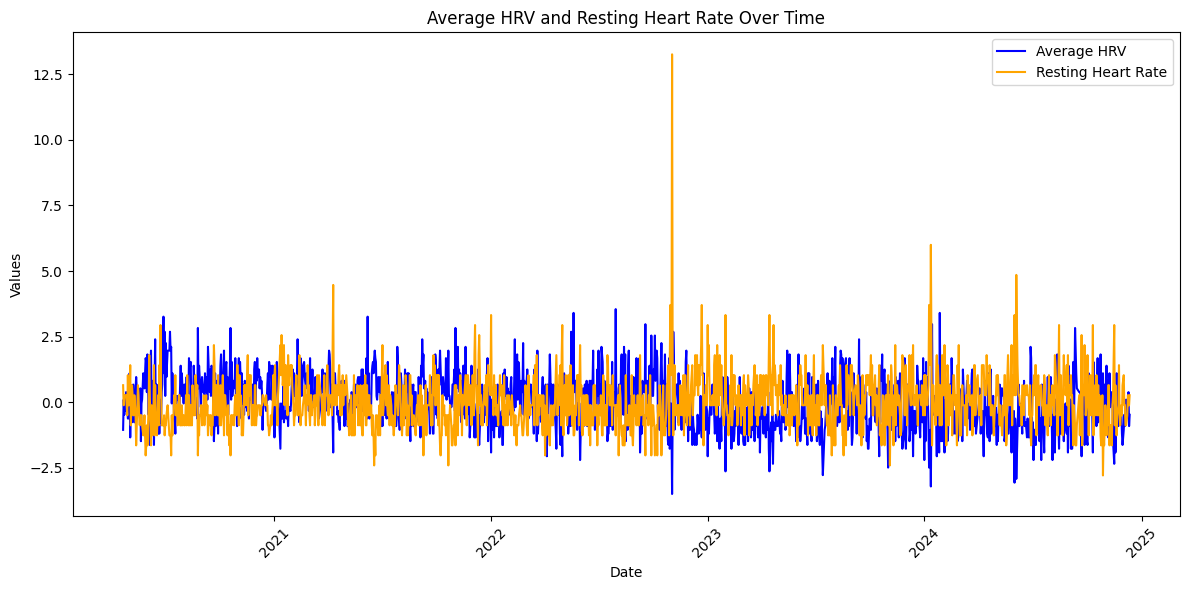

In [19]:
# plot Average HRV and Resting Heart Rate
plt.figure(figsize=(12, 6))
plt.plot(df_copy['date'], df_copy['Average HRV'], label='Average HRV', color='blue')
plt.plot(df_copy['date'], df_copy['Lowest Resting Heart Rate'], label='Resting Heart Rate', color='orange')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Average HRV and Resting Heart Rate Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()